In [3]:
# Purpose: Clean df and add alignments feature
# Authors: Noah
import pandas as pd
import numpy as np
import re

In [4]:
df = pd.read_csv('../Data/Novice.csv')

In [5]:
# Things to check alignment: Gender, Race, 

Adding 'Alignment Gender' column

In [6]:
df['Alignment Gender'] = df['Big Gender'] == df['Little Gender']

In [7]:
df['Alignment Gender']

0       True
1       True
2       True
3       True
4       True
        ... 
3270    True
3271    True
3272    True
3273    True
3274    True
Name: Alignment Gender, Length: 3275, dtype: bool

In [8]:
print(df['Alignment Gender'].sum())

3074


## Looking at data broadly - what is missing?

In [9]:
print("Initial Inspection:")
print(df.info())
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())

Initial Inspection:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Data columns (total 67 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Match ID 18Char                                    3275 non-null   object 
 1   Stage                                              3275 non-null   object 
 2   Little ID                                          3275 non-null   object 
 3   Big ID                                             3275 non-null   object 
 4   Big County                                         2620 non-null   object 
 5   Big Age                                            3275 non-null   int64  
 6   Big Occupation                                     2950 non-null   object 
 7   Big: Military                                      1231 non-null   object 
 8   Big Approved Date                                  2984 non-null   o

<Axes: >

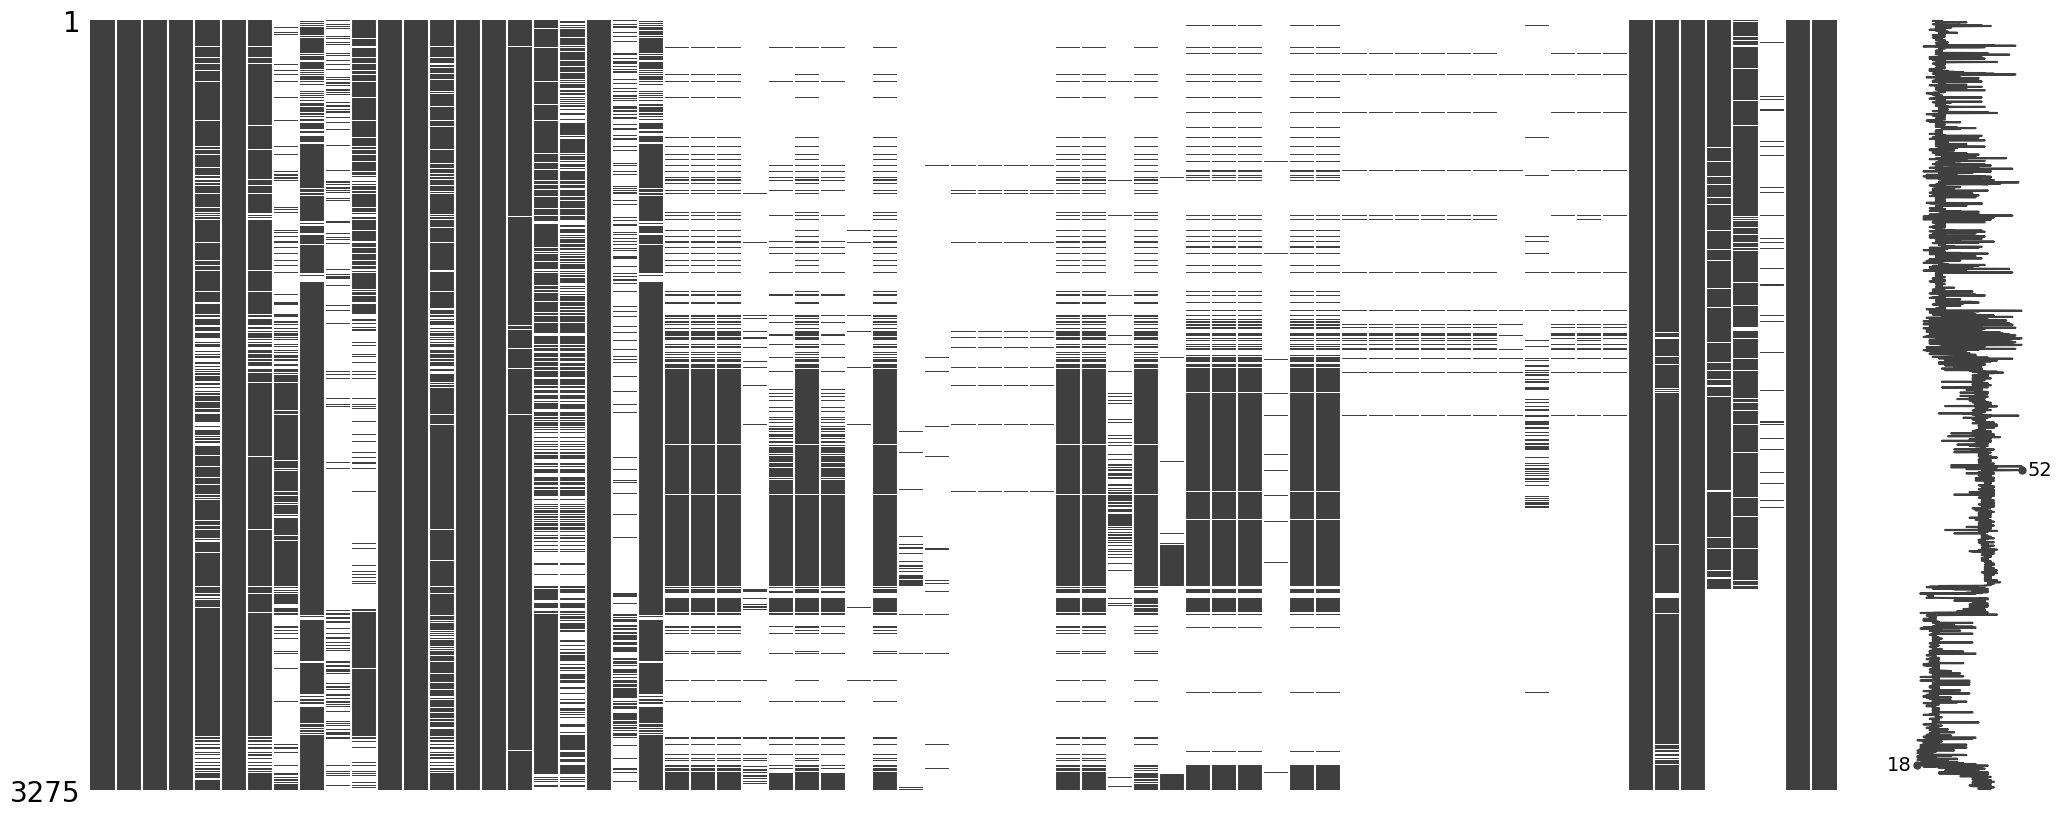

In [10]:
# Checking meaningfulness of missing values
import missingno as msno
msno.matrix(df)

                                       column  missing_count  present_count  \
22  Big Contact: Preferred Communication Type           3148            127   
32                     Little RTBM Date in MF           3027            248   
23             Big Contact: Former Big/Little           3211             64   
17               Big Days Acceptance to Match           2411            864   
19                Big Days Interview to Match           2411            864   
11                 Match Closure Meeting Date           2544            731   
30        Big Contact: Volunteer Availability           2998            277   
9                              Closure Reason            786           2489   
38                     Little Acceptance Date           1905           1370   
33                  Little RTBM in Matchforce           1904           1371   

    mean_when_missing  mean_when_present  difference  percent_difference  \
22          24.105781           5.488189   18.617592  

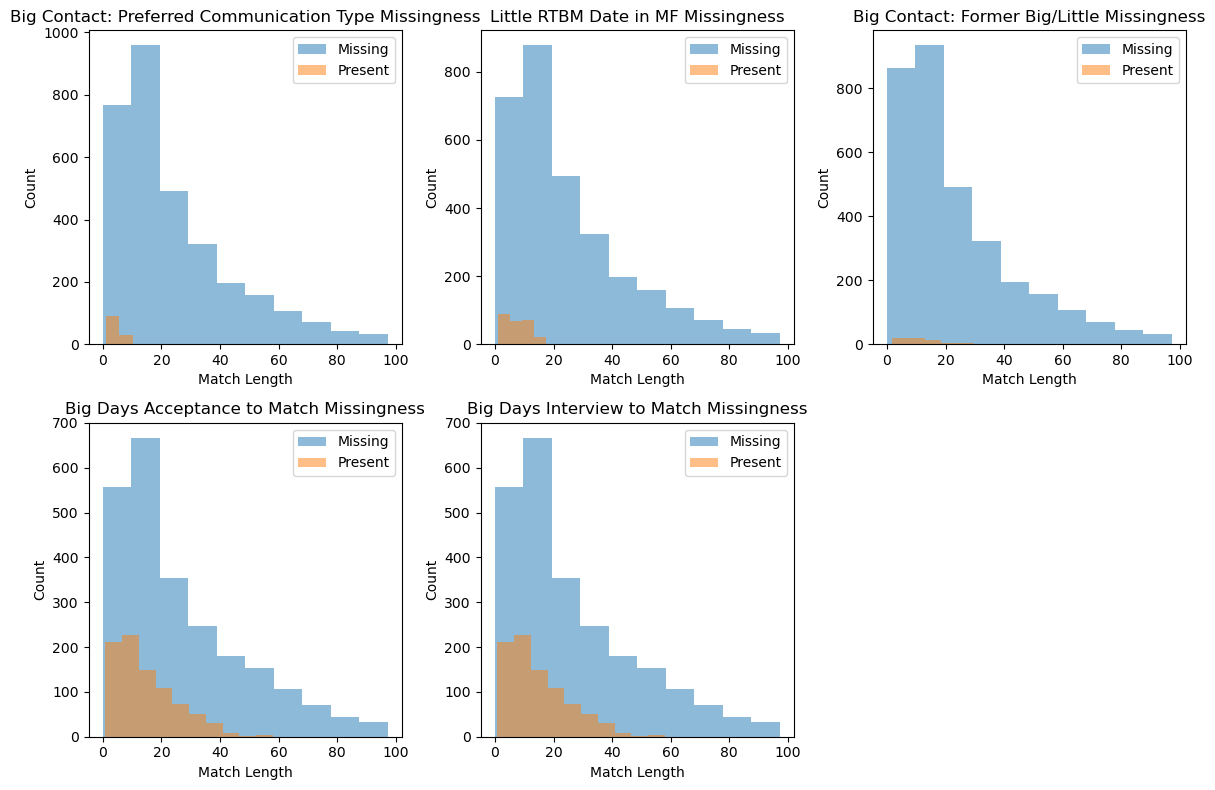

In [11]:
# Check is missingness is correlated with 'Match Length'
import matplotlib.pyplot as plt
from scipy import stats

# Function to compare match length based on missingness
def compare_match_length_by_missingness(df, column_name):
    # Create binary indicator for missingness
    is_missing = df[column_name].isna()
    
    # Extract match lengths for each group
    length_when_missing = df.loc[is_missing, 'Match Length']
    length_when_present = df.loc[~is_missing, 'Match Length']
    
    # If either group is empty, skip analysis
    if len(length_when_missing) == 0 or len(length_when_present) == 0:
        return {
            'column': column_name,
            'missing_count': sum(is_missing),
            'present_count': sum(~is_missing),
            'mean_when_missing': None,
            'mean_when_present': None,
            'p_value': None,
            'significant': None
        }
    
    # Calculate basic statistics
    mean_when_missing = length_when_missing.mean()
    mean_when_present = length_when_present.mean()
    
    # Perform t-test to check if difference is significant
    t_stat, p_value = stats.ttest_ind(
        length_when_missing, 
        length_when_present,
        equal_var=False  # Welch's t-test, doesn't assume equal variances
    )
    
    return {
        'column': column_name,
        'missing_count': sum(is_missing),
        'present_count': sum(~is_missing),
        'mean_when_missing': mean_when_missing,
        'mean_when_present': mean_when_present,
        'difference': mean_when_missing - mean_when_present,
        'percent_difference': ((mean_when_missing - mean_when_present) / mean_when_present) * 100,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

columns_to_check = [col for col in df.columns if df[col].isna().sum() > 0]
results = []

for col in columns_to_check:
    result = compare_match_length_by_missingness(df, col)
    results.append(result)

results_df = pd.DataFrame(results)

# Sort by significance and magnitude of difference
results_df = results_df.sort_values(by=['significant', 'percent_difference'], ascending=[False, False])

print(results_df[results_df['significant'] == True].head(10))

# Visualize top findings
top_columns = results_df[results_df['significant'] == True].head(5)['column'].tolist()

plt.figure(figsize=(12, 8))
for i, col in enumerate(top_columns):
    is_missing = df[col].isna()
    
    plt.subplot(2, 3, i+1)
    plt.hist(df.loc[is_missing, 'Match Length'], alpha=0.5, label='Missing')
    plt.hist(df.loc[~is_missing, 'Match Length'], alpha=0.5, label='Present')
    plt.title(f'{col} Missingness')
    plt.xlabel('Match Length')
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

Takeaways:
Missing data - not random. Longer matches systematically have more missing data. 
Standard imputation methods might introduce bias since missingness is related to your outcome variable (Match Length)
If we do impute missing values, we must use methods that can account for this relationship, such as multiple imputation with Match Length as a predictor.

What we should try:
Run analyses on different subsets of the data (e.g., only complete cases, all data with imputation). Compare results.
Use statistical approaches specifically designed for non-random missingness like Heckman selection models or inverse probability weighting.

Possible explainations? - Documentation timing bias: Some fields might typically be filled out at the end of a match. If a match ends early, there's more opportunity to complete documentation, while longer matches might still be ongoing with incomplete data.
Process changes over time: The organization may have added new fields or documentation requirements more recently. Older matches (which tend to be longer) might be missing these newer fields.

In [12]:
def is_low_variance(column, threshold=0.1):
    if pd.api.types.is_numeric_dtype(column):
        return column.std() / column.mean() < threshold
    return False

In [13]:
# Identify columns with less than 5% missing values
missing_percentage = df.isnull().mean()
columns_less_than_5_percent_missing = missing_percentage[missing_percentage < 0.05].index.tolist()

# Impute missing values for columns with less than 5% missing values and low variance
for column in columns_less_than_5_percent_missing:
    if df[column].isnull().sum() > 0:  # Check if the column has missing values
        if pd.api.types.is_numeric_dtype(df[column]) and is_low_variance(df[column]):
            # Impute numerical columns with mean
            df[column].fillna(df[column].mean(), inplace=True)
        elif pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
            # Impute categorical columns with mode
            df[column].fillna(df[column].mode()[0], inplace=True)

/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_42354/1754024543.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_42354/1754024543.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)


In [14]:
print("Inspection after Imputing Data with less than 5% missing:")
print(df.info())
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())

Inspection after Imputing Data with less than 5% missing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Data columns (total 67 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Match ID 18Char                                    3275 non-null   object 
 1   Stage                                              3275 non-null   object 
 2   Little ID                                          3275 non-null   object 
 3   Big ID                                             3275 non-null   object 
 4   Big County                                         2620 non-null   object 
 5   Big Age                                            3275 non-null   int64  
 6   Big Occupation                                     2950 non-null   object 
 7   Big: Military                                      1231 non-null   object 
 8   Big Approved Date             

Looking at 'Rationale for Match'

In [27]:
summary_stats = df['Rationale for Match'].describe()
print("Summary Statistics for 'Rationale for Match':") 
print(summary_stats)
df['Rationale for Match']

Summary Statistics for 'Rationale for Match':
count     2976
unique    2803
top          .
freq        62
Name: Rationale for Match, dtype: object


0                                                     NaN
1       Their shared interests include spending time o...
2                                                     NaN
3       B_first_name and L_first_name were matched bec...
4       Shared interests like being creative and tryin...
                              ...                        
3270    -BS and LS are both Black/African-American, BS...
3271    - B_first_name (BS) and L_first_name (LS) are ...
3272    - B_first_name (BS) and L_first_name (LS) are ...
3273    B_first_name (BB) and L_first_name (LB) are a ...
3274    - Josh (BB) and L_first_name (LB) are a new ma...
Name: Rationale for Match, Length: 3275, dtype: object

Creating interest category features...
- interest_sports: 910 matches (27.8% of all records)
- interest_arts: 1177 matches (35.9% of all records)
- interest_outdoors: 782 matches (23.9% of all records)
- interest_academics: 794 matches (24.2% of all records)
- interest_technology: 270 matches (8.2% of all records)
- interest_social: 381 matches (11.6% of all records)
- interest_food: 334 matches (10.2% of all records)
- interest_cultural: 41 matches (1.3% of all records)
- interest_personality_traits: 1923 matches (58.7% of all records)
- interest_family: 669 matches (20.4% of all records)

Found 159 common interests appearing in > 3% of records:
outdoors, caring, animals, riding, learning, trying, things, live, miles, away, other, l_first_name, selected, b_first_name, outgoing, curious, friendly, love, thoughtful, adventurous, ...
- has_outdoors: 707 matches (21.6% of records)
- has_caring: 140 matches (4.3% of records)
- has_animals: 319 matches (9.7% of records)
- has_riding: 140 ma

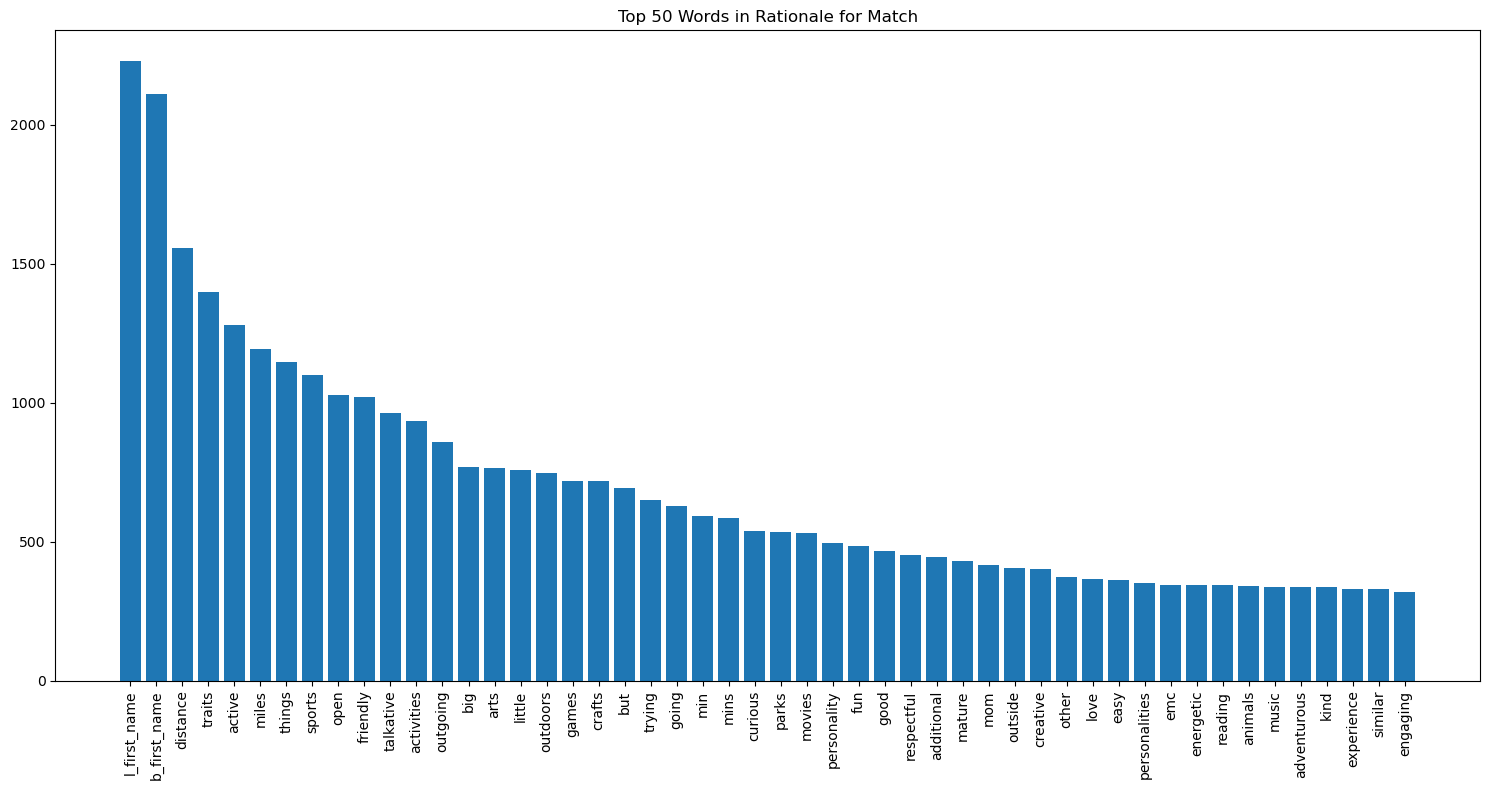

In [28]:
import re
from collections import Counter
import seaborn as sns

# First, we'll clean and prepare the text
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and extra spaces
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Apply cleaning to non-null values
rationales = df['Rationale for Match'].dropna().apply(clean_text)

# Create a list of common interest categories to search for
interest_categories = {
    'sports': ['sport', 'baseball', 'basketball', 'football', 'soccer', 'tennis', 'golf', 
               'swimming', 'hockey', 'volleyball', 'athletic', 'exercise', 'gym', 'workout',
               'running', 'biking', 'skating', 'skiing', 'snowboarding', 'martial arts'],
    'arts': ['art', 'drawing', 'painting', 'music', 'singing', 'dancing', 'crafts', 'creative',
             'writing', 'poetry', 'theatre', 'drama', 'acting', 'photography', 'playing music',
             'instrument', 'band', 'choir', 'piano', 'guitar'],
    'outdoors': ['outdoor', 'hiking', 'camping', 'fishing', 'hunting', 'nature', 'gardening',
                'environmental', 'animals', 'wildlife', 'birds', 'park', 'beach', 'forest', 'mountain'],
    'academics': ['school', 'learning', 'study', 'education', 'academic', 'reading', 'books',
                 'science', 'math', 'history', 'homework', 'college', 'university', 'teaching',
                 'student', 'classroom', 'grades', 'tutor'],
    'technology': ['technology', 'computer', 'coding', 'programming', 'video games', 'gaming',
                  'online', 'internet', 'digital', 'software', 'hardware', 'engineering',
                  'electronics', 'robotics', 'tech'],
    'social': ['social', 'talking', 'conversation', 'friends', 'relationships', 'community',
              'leadership', 'communication', 'group', 'teamwork', 'helping others', 'volunteer'],
    'food': ['food', 'cooking', 'baking', 'eating', 'restaurant', 'cuisine', 'meal', 'recipe',
            'culinary', 'chef', 'dinner', 'lunch', 'breakfast', 'snack', 'dessert'],
    'cultural': ['culture', 'language', 'heritage', 'tradition', 'religious', 'spiritual',
               'ethnic', 'diversity', 'identity', 'cultural activities'],
    'personality_traits': ['shy', 'outgoing', 'quiet', 'talkative', 'energetic', 'calm', 'patient',
                          'creative', 'organized', 'responsible', 'humor', 'funny', 'serious',
                          'thoughtful', 'kind', 'caring', 'empathetic', 'confident'],
    'family': ['family', 'parent', 'sibling', 'brother', 'sister', 'mom', 'dad', 'grandparent',
              'family activities', 'family time', 'home', 'household']
}

# Function to check if any keyword in a category appears in the text
def check_category_keywords(text, keywords):
    for keyword in keywords:
        # Use word boundaries to match whole words only
        pattern = r'\b' + re.escape(keyword) + r'\b'
        if re.search(pattern, text):
            return True
    return False

# Create new columns for each interest category
print("Creating interest category features...")
for category, keywords in interest_categories.items():
    column_name = f'interest_{category}'
    # Initialize the column with False
    df[column_name] = False
    # Set to True where the rationale contains at least one keyword from the category
    df.loc[df['Rationale for Match'].notna(), column_name] = df.loc[df['Rationale for Match'].notna(), 'Rationale for Match'].apply(
        lambda x: check_category_keywords(clean_text(x), keywords)
    )
    # Count occurrences
    count = df[column_name].sum()
    print(f"- {column_name}: {count} matches ({count/len(df)*100:.1f}% of all records)")

# Extract all individual words for frequency analysis
all_words = ' '.join(rationales).split()
word_freq = Counter(all_words)

# Remove common stop words
stop_words = ['the', 'and', 'to', 'in', 'of', 'a', 'for', 'with', 'are', 'that', 'is', 'they', 'have', 'as', 'their', 'both', 'were', 'has', 'be', 'this', 'will', 'an', 'at', 'on', 'was', 'by', 'share', 'shared', 'sharing', 'interests', 'interest', 'would', 'also', 'because', 'been', 'being', 'can', 'common', 'do', 'does', 'each', 'enjoy', 'enjoys', 'first', 'from', 'had', 'has', 'have', 'his', 'her', 'how', 'i', 'if', 'it', 'its', 'more', 'new', 'not', 'one', 'or', 'our', 'out', 'same', 'she', 'he', 'so', 'some', 'such', 'than', 'them', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'time', 'very', 'what', 'when', 'which', 'who', 'why', 'you', 'your', 'name', 'like', 'likes', 'including', 'include', 'well', 'just', 'about', 'think', 'want', 'wants', 'able', 'all', 'any', 'are', 'bs', 'ls', 'bb', 'lb', 'bbbs', 'match', 'matches', 'matched']
filtered_words = {word: count for word, count in word_freq.items() if word not in stop_words and len(word) > 2}

# Get top 50 most common words
top_words = dict(sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)[:50])

# Plot the top words
plt.figure(figsize=(15, 8))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=90)
plt.title('Top 50 Words in Rationale for Match')
plt.tight_layout()

# Create a new feature for each common interest that appears frequently
threshold = len(df) * 0.03  # 3% of records
common_interests = [word for word, count in filtered_words.items() if count > threshold]
print(f"\nFound {len(common_interests)} common interests appearing in > 3% of records:")
print(", ".join(common_interests[:20]) + (", ..." if len(common_interests) > 20 else ""))

# Create binary features for the most common interests
for interest in common_interests[:20]:  # Limit to top 20 to avoid too many features
    column_name = f'has_{interest}'
    # Initialize to False
    df[column_name] = False
    # Set to True where the rationale contains this interest
    df.loc[df['Rationale for Match'].notna(), column_name] = df.loc[
        df['Rationale for Match'].notna(), 'Rationale for Match'
    ].apply(lambda x: interest in clean_text(x).split())
    # Count occurrences
    count = df[column_name].sum()
    print(f"- {column_name}: {count} matches ({count/len(df)*100:.1f}% of records)")

# Analyze the relationship between interests and match length
print("\nAnalyzing relationship between interests and match length...")
interest_columns = [col for col in df.columns if col.startswith('interest_') or col.startswith('has_')]

for col in interest_columns:
    # Calculate average match length when interest is present vs. absent
    avg_length_present = df.loc[df[col], 'Match Length'].mean()
    avg_length_absent = df.loc[~df[col], 'Match Length'].mean()
    diff_percent = ((avg_length_present - avg_length_absent) / avg_length_absent * 100 
                    if avg_length_absent > 0 else float('inf'))
    
    print(f"- {col}: Present: {avg_length_present:.1f} months, Absent: {avg_length_absent:.1f} months " +
          f"(Difference: {diff_percent:+.1f}%)")

# Create a summary dataframe of interest impact on match length
interest_impact = []

for col in interest_columns:
    avg_present = df.loc[df[col], 'Match Length'].mean()
    avg_absent = df.loc[~df[col], 'Match Length'].mean()
    diff_percent = ((avg_present - avg_absent) / avg_absent * 100 
                    if avg_absent > 0 else float('inf'))
    count_present = df[col].sum()
    
    interest_impact.append({
        'interest': col,
        'avg_length_present': avg_present,
        'avg_length_absent': avg_absent,
        'diff_percent': diff_percent,
        'count': count_present,
        'percent_records': count_present / len(df) * 100
    })

interest_impact_df = pd.DataFrame(interest_impact)
interest_impact_df = interest_impact_df.sort_values('diff_percent', ascending=False)

# Display the top 10 interests that are most strongly associated with longer matches
print("\nTop 10 interests associated with LONGER matches:")
print(interest_impact_df.head(10)[['interest', 'avg_length_present', 'avg_length_absent', 'diff_percent', 'count', 'percent_records']])

# Display the bottom 10 interests that are most strongly associated with shorter matches
print("\nTop 10 interests associated with SHORTER matches:")
print(interest_impact_df.tail(10)[['interest', 'avg_length_present', 'avg_length_absent', 'diff_percent', 'count', 'percent_records']])

In [30]:
print("Initial Inspection:")
print(df.info())
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())

Initial Inspection:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Data columns (total 97 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Match ID 18Char                                    3275 non-null   object 
 1   Stage                                              3275 non-null   object 
 2   Little ID                                          3275 non-null   object 
 3   Big ID                                             3275 non-null   object 
 4   Big County                                         2620 non-null   object 
 5   Big Age                                            3275 non-null   int64  
 6   Big Occupation                                     2950 non-null   object 
 7   Big: Military                                      1231 non-null   object 
 8   Big Approved Date                                  2984 non-null   o

Looking at 'Big Days Acceptance to Match'

In [15]:
summary_stats = df['Big Days Acceptance to Match'].describe()
print("Summary Statistics for 'Big Days Acceptance to Match':") # there are negative numbers in here - how?
print(summary_stats)


Summary Statistics for 'Big Days Acceptance to Match':
count     864.000000
mean      113.488426
std       151.668060
min      -298.000000
25%        34.000000
50%        57.000000
75%       124.250000
max      1132.000000
Name: Big Days Acceptance to Match, dtype: float64


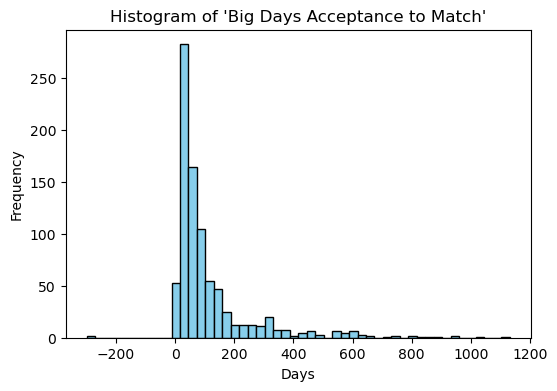

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(df['Big Days Acceptance to Match'], bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of 'Big Days Acceptance to Match'")
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Negative value seems to be an outlier
df_filtered = df[df['Big Days Acceptance to Match'] >= 0]

Trying a Regressor model to do predictive imputation on data based on other variables

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Set a seed for reproducibility
np.random.seed(8080)

# Define features and target
features = [
    'Big Age',
    'Big Occupation', 
    'Program', 
    'Match Length',  
    'Match Activation Date', 
    'Big Gender',
    'Big Race/Ethnicity',
    'Big County',
    'Program Type',
    'Big Enrollment: Record Type',
    'Big Birthdate',
    'Big Approved Date',
    'Big Re-Enroll'
]
target = 'Big Days Acceptance to Match'

# Filter rows with and without missing values in the target column
df_missing = df[df[target].isnull()] # test
df_not_missing = df_filtered.dropna(subset=[target]) # training
 
# Check if there are missing values to impute
if not df_missing.empty and not df_not_missing.empty:
    # Separate features and target for rows without missing target values
    X = df_not_missing[features]
    y = df_not_missing[target]

    categorical_features = [
        'Big Occupation', 
        'Program', 
        'Big Gender', 
        'Big Race/Ethnicity', 
        'Big County', 
        'Program Type', 
        'Big Enrollment: Record Type',
        'Big Re-Enroll'
    ]
    
    date_features = [
        'Match Activation Date',
        'Big Birthdate',
        'Big Approved Date'
    ]
    
    numerical_features = [
        'Big Age',
        'Match Length'
    ]

    # Convert date features to numeric (e.g., days since a reference date)
    reference_date = pd.to_datetime('1940-01-01')  # Choose a reference date
    for date_col in date_features:
        X[date_col] = (pd.to_datetime(X[date_col]) - reference_date).dt.days
        df_missing[date_col] = (pd.to_datetime(df_missing[date_col]) - reference_date).dt.days

    # One-hot encode categorical features
        preprocessor = ColumnTransformer(
            transformers=[
                # For categorical features: impute missing values, then one-hot encode
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('encoder', OneHotEncoder(handle_unknown='ignore'))
                ]), categorical_features),
                
                # For numerical features: impute missing values, then scale
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), numerical_features),
                
                # For date features: impute missing values, then scale
                ('date', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), date_features)
            ],
            remainder='drop'  # Drop any columns not specified
        )

    # Create a pipeline with preprocessing and the RandomForestRegressor model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ])

    # Define a parameter grid for GridSearchCV
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }

    # Set up K-Fold Cross-Validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform GridSearchCV with K-Fold Cross-Validation
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=kfold,
        scoring='neg_mean_absolute_error',  # Use MAE as the scoring metric
        n_jobs=-1  # Use all available CPU cores
    )

    # Train the model using GridSearchCV
    grid_search.fit(X, y)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best MAE Score:", -grid_search.best_score_)  # Convert back to positive MAE

    # Evaluate the model on the validation set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    print(f"Validation Metrics:\n"
          f"Mean Absolute Error (MAE): {mae:.2f}\n"
          f"Mean Squared Error (MSE): {mse:.2f}\n"
          f"Root Mean Squared Error (RMSE): {rmse:.2f}\n"
          f"R-squared (R2): {r2:.2f}")

    # Predict missing values
    X_test = df_missing[features]
    df_missing[target] = best_model.predict(X_test)

    # Combine the dataframes to get the final dataset with imputed values
    df_imputed = pd.concat([df_not_missing, df_missing])

    # Reset index if necessary
    df_imputed.reset_index(drop=True, inplace=True)

    #df_imputed.to_csv('Novice_Imputed.csv', index=False)

    print("Missing values have been imputed and the dataset is saved as 'Novice_Imputed.csv'.")
else:
    print("No missing values to impute or insufficient data for modeling.")

/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_42354/420968541.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[date_col] = (pd.to_datetime(X[date_col]) - reference_date).dt.days
/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_42354/420968541.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing[date_col] = (pd.to_datetime(df_missing[date_col]) - reference_date).dt.days
/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_42354/420968541.py:65: SettingWithCopyWar

Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 50}
Best MAE Score: 63.1851045951862
Validation Metrics:
Mean Absolute Error (MAE): 39.68
Mean Squared Error (MSE): 3698.67
Root Mean Squared Error (RMSE): 60.82
R-squared (R2): 0.84
Missing values have been imputed and the dataset is saved as 'Novice_Imputed.csv'.


/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_42354/420968541.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing[target] = best_model.predict(X_test)


## Ridge Regression for Feature Selection

Note: 'Rationale for Match' has 2803 unique values. Treating as high cardinality categorical.
Categorical features: ['Big Gender', 'Big Race/Ethnicity', 'Little Gender', 'Little Participant: Race/Ethnicity', 'Big County', 'Program', 'Program Type', 'Big Occupation', 'Stage']
Numerical features: ['Big Age', 'Alignment Gender']
Running GridSearchCV...
Best Parameters: {'regressor__alpha': 10.0}
Best RMSE Score: 18.1350513909626

Test Set Metrics:
Mean Absolute Error (MAE): 13.66
Root Mean Squared Error (RMSE): 18.03
R-squared (R²): 0.171
Number of features: 230
Number of coefficients: 230

Top 20 Most Important Features:
                                               Feature  Importance
227                              Stage_Pending Closure   10.887161
226                                       Stage_Closed   10.839208
122                           Program_STEM Cohort 2025   10.428471
44         Little Participant: Race/Ethnicity_Hispanic    8.109125
126       Program_Sports Buddies Cohor

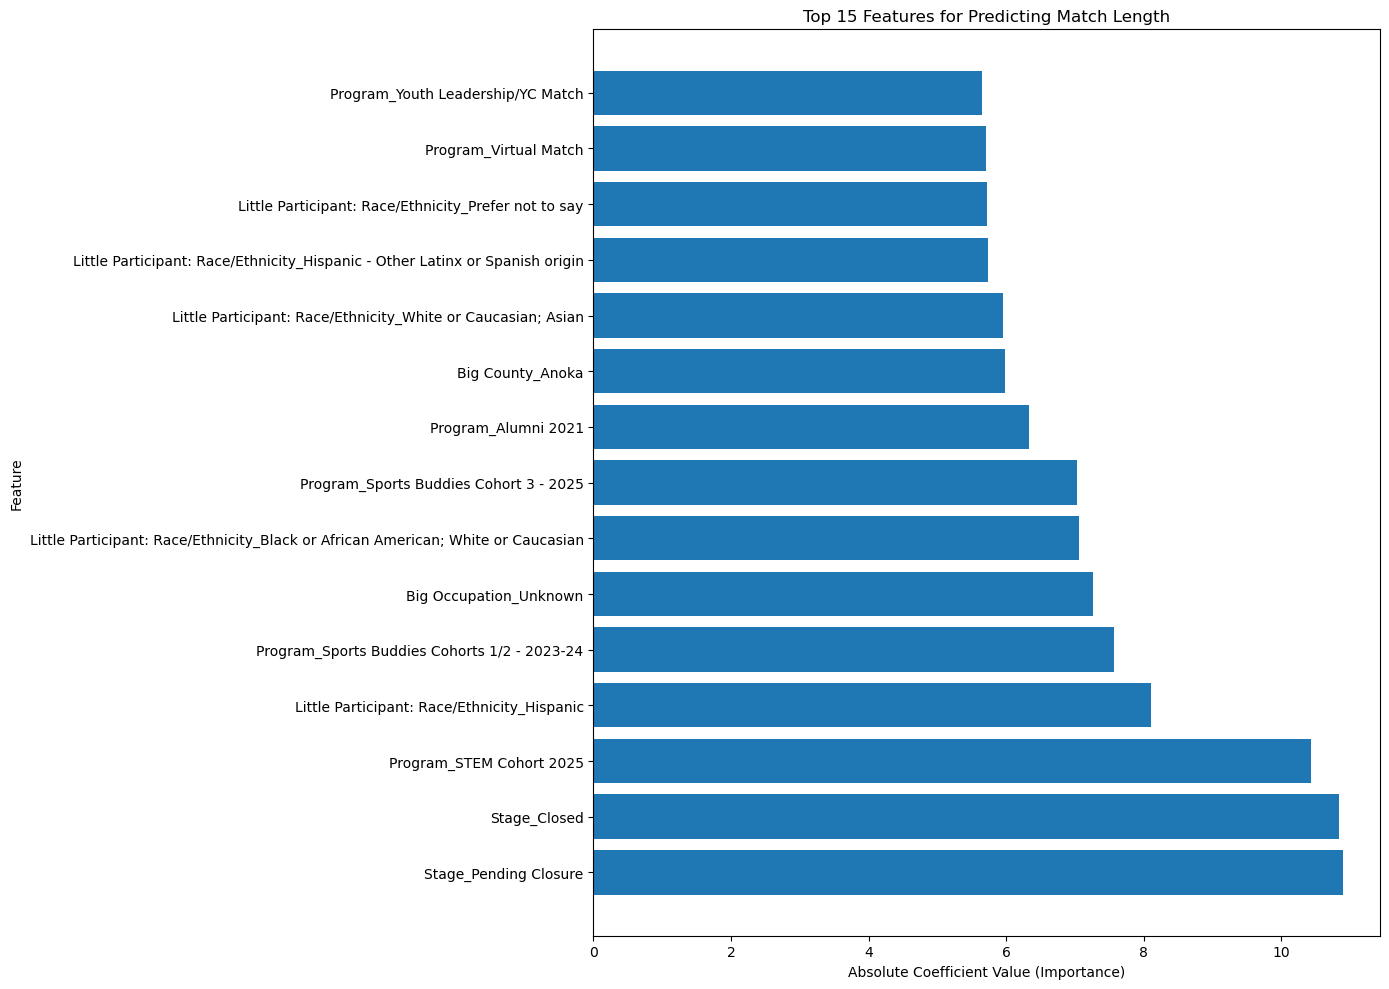

In [19]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

np.random.seed(8080)

# Select features that might predict Match Length
features = [
    'Big Age',
    'Big Gender',
    'Big Race/Ethnicity',
    'Little Gender',
    'Little Participant: Race/Ethnicity',
    'Big County',
    'Program',
    'Program Type',
    'Big Occupation',
    'Alignment Gender',  # This is the boolean causing issues - CLASSIFICATIONS CAN CAUSE ISSUES
    'Stage',
    'Rationale for Match'
]

target = 'Match Length'

# Clean the data - drop rows where target is missing
df_clean = df.dropna(subset=[target])

# Make a copy of the data to avoid SettingWithCopyWarning
X = df_clean[features].copy()
y = df_clean[target].copy()

# Convert boolean to integer (0 or 1) to fix the SimpleImputer issue
X['Alignment Gender'] = X['Alignment Gender'].astype(int)

# Identify feature types
categorical_features = [
    'Big Gender', 
    'Big Race/Ethnicity', 
    'Little Gender',
    'Little Participant: Race/Ethnicity',
    'Big County', 
    'Program', 
    'Program Type', 
    'Big Occupation',
    'Stage'
]

# If it has too many unique values, it might cause issues with one-hot encoding
if X['Rationale for Match'].nunique() > 100:
    X = X.drop('Rationale for Match', axis=1)
else:
    categorical_features.append('Rationale for Match')

# Treat the converted boolean as numerical
numerical_features = ['Big Age', 'Alignment Gender']

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Handle missing values before creating pipeline
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])

for col in numerical_features:
    X[col] = X[col].fillna(X[col].median())

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='drop'
)

# Create the pipeline
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Perform GridSearchCV
print("Running GridSearchCV...")
grid_search = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE Score:", np.sqrt(-grid_search.best_score_))

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.3f}")

# Get the fitted preprocessor from the pipeline
fitted_preprocessor = best_model.named_steps['preprocessor']

# Get feature names from the transformers
cat_transformer_info = fitted_preprocessor.transformers_[0]
cat_encoder = cat_transformer_info[1]  # The actual transformer
cat_columns = cat_transformer_info[2]  # The column indices
cat_feature_names = cat_encoder.get_feature_names_out()

# Combine with numerical feature names
feature_names = np.concatenate([cat_feature_names, numerical_features])

# Get coefficients from the Ridge regressor
coefficients = best_model.named_steps['regressor'].coef_

# Check if lengths match
print(f"Number of features: {len(feature_names)}")
print(f"Number of coefficients: {len(coefficients)}")

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)  # Using absolute values
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Print top 20 important features
print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(14, 10))
top_features = feature_importance.head(15)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Absolute Coefficient Value (Importance)')
plt.ylabel('Feature')
plt.title('Top 15 Features for Predicting Match Length')
plt.tight_layout()
plt.show()

# Save the results
#feature_importance.to_csv('ridge_regression_importance.csv', index=False)

In [20]:
#df.to_csv('your_file.csv', index=False)

## More Alignments

In [21]:
df['Big Contact: Interest Finder - Sports']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
3270    NaN
3271    NaN
3272    NaN
3273    NaN
3274    NaN
Name: Big Contact: Interest Finder - Sports, Length: 3275, dtype: object

In [22]:
filtered_df = df.dropna(subset=['Big Contact: Interest Finder - Sports'])
filtered_df['Big Contact: Interest Finder - Sports']

9       Bowling; Frisbee; Golf/mini golf; Hockey; Ping...
262                                               Bowling
599     Basketball; Frisbee; Rollerskating/blading; Te...
618           Bowling; Frisbee; Golf/mini golf; Ping Pong
636              Bowling; Rollerskating/blading; Swimming
725     Basketball; Bowling; Football; Frisbee; Golf/m...
726     Basketball; Bowling; Football; Frisbee; Golf/m...
737                                        Hockey; Tennis
946     Bowling; Frisbee; Golf/mini golf; Ping Pong; S...
1172    Bowling; Golf/mini golf; Rollerskating/blading...
1324    Baseball/Softball; Basketball; Bowling; Golf/m...
1350    Bowling; Football; Frisbee; Golf/mini golf; Ma...
1381                                           None/Other
1389    Bowling; Frisbee; Golf/mini golf; Ping Pong; R...
1392       Baseball/Softball; Bowling; Frisbee; Ping Pong
1423    Basketball; Bowling; Football; Rollerskating/b...
1447    Baseball/Softball; Bowling; Golf/mini golf; Gy...
1478    Baseba

In [23]:
df['Little Contact: Interest Finder - Sports']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
3270    NaN
3271    NaN
3272    NaN
3273    NaN
3274    NaN
Name: Little Contact: Interest Finder - Sports, Length: 3275, dtype: object

In [24]:
filtered_df = df.dropna(subset=['Little Contact: Interest Finder - Sports'])
filtered_df['Little Contact: Interest Finder - Sports']

107     Baseball/Softball; Basketball; Bowling; Gymnas...
109     Baseball/Softball; Basketball; Bowling; Gymnas...
142                                              Swimming
145                                              Swimming
147                                              Swimming
                              ...                        
1682             Bowling; Football; Rollerskating/blading
1891    Basketball; Football; Frisbee; Golf/mini golf;...
1897    Baseball/Softball; Basketball; Bowling; Footba...
1913    Basketball; Bowling; Frisbee; Golf/mini golf; ...
1914    Basketball; Bowling; Frisbee; Golf/mini golf; ...
Name: Little Contact: Interest Finder - Sports, Length: 80, dtype: object